# Project Guidance

https://ds.codeup.com/nlp/project/

## Acquisition + Preparation

For this project, you will have to build a dataset yourself. Decide on a list of GitHub repositories to scrape, and use the provided script to acquire the README data for each repository. The repositories you use are up to you, but you should include at least 100 repositories in your data set.
As an example of which repositories to use, here is a link to GitHub's trending repositories, the most forked repositories, and the most starred repositories.

https://github.com/trending

https://github.com/search?o=desc&q=stars:%3E1&s=forks&type=Repositories

https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories

The list of repositories could be generated programatically using web scraping techniques.
Make sure to document where your data comes from. All of the pages linked above change over time, so it would be wise to say something like: "Our data comes from the top 100 trending repositories on GitHub as of $DATE".

## Exploration

Explore and visualize the natural language data that you have acquired. Here are some ideas for exploration:

- What are the most common words in READMEs?

- Does the length of the README vary by programming language?

- Do different programming languages use a different number of unique words?

- Are there any words that uniquely identify a programming language?

## Modeling

- Transform your documents into a form that can be used in a machine learning model. You should use the programming language of the repository as the label to predict.

- Try fitting several different models and using several different representations of the text (e.g. a simple bag of words, then also the TF-IDF values for each).

- Build a function that will take in the text of a README file and try to predict the programming language.

- If you have many different unique values in your target variable, consider narrowing down this list. For example, use the top 3 languages and then label everything else as "Other" so that you have fewer unique values to predict.

# **Github Programming Language Predictor**
##### **using Natural Language Processing**
<p align ="right">Zacharia Schmitz <br>
October 2023

---


### Rate Limits & Ethics:

Scraping

[**From GitHub Acceptable Use Policies**](https://docs.github.com/en/github/site-policy/github-acceptable-use-policies)

>"Short version: We host a wide variety of collaborative projects from all over the world, and that collaboration only works when our users are able   >to work together in good faith. While using the Service, you must comply with our Acceptable Use Policies, which include some restrictions on content >and conduct on GitHub related to user safety, intellectual property, privacy, authenticity, and other limitations. In short, be excellent to each
>other.


### Tools Utilized: 

XXXXXXXXXXXX

<div style="background-color: #; padding: 0px; ">

## <font size='10'><i>**Plan**</i></font> <font size='5'><i>→ Acquire → Prepare → Explore → Model → Deliver</i></font>

---

We'll pull 20 README pages from each language and analyze each one individually.

1. Decide Languages
2. Acquire Repos
3. Data Cleaning
4. Text Preprocessing
5. Feature Extraction
6. Model Training

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → </i></font> <font size='10'><i>**Acquire**</i></font> <font size='5'><i> → Prepare → Explore → Model → Deliver</i></font>

---

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pickle

### Which Languages:

First we wanted to decide on the top languages we're interested in. 

We ended up going with: Python, C#, C++, JavaScript, PHP, Swift, Java, Go, R, and Ruby

### Scrape the URLs of Trending Repositories on GitHub for each coding language, and limited to English:

For each language, visit the URL https://github.com/trending/ + **{language}** + ?since=daily&spoken_language_code=en.

Extract the URLs of the top trending repositories. This required parsing the HTML with BeautifulSoup, and finding the repo. 

### Scrape README files from each Repository URL:

Once we had the repo name, we then pulled the README from https://github.com" + **{repo}** + "/blob/master/README.md

If the README was not posted on master and returned error code 404, we then skipped to the next repo, but didn't increment our counter (all languages had 20).

### Extract the content of the README file:

Once extracted, we stored the extracted README content for each language in a CSV file with language, repo, and the context of the README.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def gitscraper(language, num_repos=20, status=True):
    base = "https://github.com/trending/"
    page_num = 1
    repo_links = []
    
    while len(repo_links) < num_repos:
        response = requests.get(base + language + f"?since=daily&spoken_language_code=en&page={page_num}")
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract repository URLs
        repo_links.extend([a['href'] for a in soup.select('.h3 a')])

        # If we have less than 24 repos on the current page, then we've reached the last page
        if len(soup.select('.h3 a')) < 24:
            break
        
        page_num += 1
    
    count = 0
    extracted_data = []
    for repo in repo_links:
        if count >= num_repos:
            print(f'Successfully fetched {num_repos} READMEs for {language}.\n')
            break

        if status:
            print(f'Attempting to get README for {language} repo {repo} ({count + 1} of {num_repos}).')
        
        # Construct the README URL directly
        readme_url = "https://github.com" + repo + "/blob/master/README.md"
        response = requests.get(readme_url)
        
        if response.status_code == 404:
            if status:
                print(f'README not on MAIN. Skipping to next. 404 on {language} number {count + 1} ({repo})')
            continue
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Try a more general selector
        readme_content = soup.select_one('article')
        if readme_content is not None:
            readme_content = readme_content.get_text()
            extracted_data.append((language, repo, readme_content))
            count += 1
            if status:
                print(f'Success.\n')
        else:
            if status:
                print(f"Failed to extract README content for {readme_url}. Repo number {count + 1} ({repo}).")
    
    # Convert to a dataframe
    extracted_data = pd.DataFrame(extracted_data, columns = ['language', 'repo', 'readme'])
    
    return extracted_data


In [3]:
# Test it out
gitscraper('python', 1, True)

Attempting to get README for python repo /mindsdb/mindsdb (1 of 1).
Success.

Successfully fetched 1 READMEs for python.



,language,repo,readme
0,python,/mindsdb/mindsdb,\n\t\n\t\n\n\n\n\n\n\n\t\n\t\n\t\n\t\n\t \n\t\...


### Check GitHub Rate Limit

In [79]:
# Check current rate limit with GitHub (does not count towards limit)

response = requests.get('https://api.github.com/rate_limit')
response.json()

# Seems to be only affected by API requests, not scraping

{'resources': {'core': {'limit': 60,
   'remaining': 60,
   'reset': 1697515150,
   'used': 0,
   'resource': 'core'},
  'graphql': {'limit': 0,
   'remaining': 0,
   'reset': 1697515150,
   'used': 0,
   'resource': 'graphql'},
  'integration_manifest': {'limit': 5000,
   'remaining': 5000,
   'reset': 1697515150,
   'used': 0,
   'resource': 'integration_manifest'},
  'search': {'limit': 10,
   'remaining': 10,
   'reset': 1697511610,
   'used': 0,
   'resource': 'search'}},
 'rate': {'limit': 60,
  'remaining': 60,
  'reset': 1697515150,
  'used': 0,
  'resource': 'core'}}

### Gather Repos

In [80]:
languages = ["python", "javascript", "java", "ruby", "go", "c%23", "c++", "php", "r"]

all_data = []

for lang in languages:
    data = gitscraper(lang, num_repos=100, status=True)
    all_data.append(data)

Attempting to get README for python repo /mindsdb/mindsdb (1 of 100).
Success.

Attempting to get README for python repo /yt-dlp/yt-dlp (2 of 100).
Success.

Attempting to get README for python repo /Ebazhanov/linkedin-skill-assessments-quizzes (3 of 100).
Success.

Attempting to get README for python repo /OpenTalker/video-retalking (4 of 100).
Success.

Attempting to get README for python repo /hummingbot/hummingbot (5 of 100).
Success.

Attempting to get README for python repo /donnemartin/system-design-primer (6 of 100).
Success.

Attempting to get README for python repo /python/mypy (7 of 100).
Success.

Attempting to get README for python repo /chaiNNer-org/chaiNNer (8 of 100).
Success.

Attempting to get README for python repo /swirlai/swirl-search (9 of 100).
Success.

Attempting to get README for python repo /ranaroussi/yfinance (10 of 100).
Success.

Attempting to get README for python repo /sympy/sympy (11 of 100).
Success.

Attempting to get README for python repo /pwndbg/p

In [81]:
all_data

[   language                                           repo  \
 0    python                               /mindsdb/mindsdb   
 1    python                                 /yt-dlp/yt-dlp   
 2    python  /Ebazhanov/linkedin-skill-assessments-quizzes   
 3    python                    /OpenTalker/video-retalking   
 4    python                         /hummingbot/hummingbot   
 ..      ...                                            ...   
 91   python                               /BlinkDL/RWKV-LM   
 92   python                               /wagtail/wagtail   
 93   python                  /swaggyP36000/TrollStore-IPAs   
 94   python                             /danielgatis/rembg   
 95   python        /GoogleCloudPlatform/microservices-demo   
 
                                                readme  
 0   \n\t\n\t\n\n\n\n\n\n\n\t\n\t\n\t\n\t\n\t \n\t\...  
 1   \n\n\n\n\n\n\n\n\n\n\n\n\n\n\nyt-dlp is a yout...  
 2   Linkedin Skill assessments - Answers\n\n\n\n\n...  
 3   \nVideoRe

In [82]:
# Concatenate all the dataframes into one
combined_data = pd.concat(all_data, ignore_index=True)

In [83]:
combined_data

,language,repo,readme
0,python,/mindsdb/mindsdb,\n\t\n\t\n\n\n\n\n\n\n\t\n\t\n\t\n\t\n\t \n\t\...
1,python,/yt-dlp/yt-dlp,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nyt-dlp is a yout...
2,python,/Ebazhanov/linkedin-skill-assessments-quizzes,Linkedin Skill assessments - Answers\n\n\n\n\n...
3,python,/OpenTalker/video-retalking,\nVideoReTalking Audio-based Lip Synchronizat...
4,python,/hummingbot/hummingbot,\n\n\n\n\n\nHummingbot is an open source fram...
...,...,...,...
783,r,/insightsengineering/teal.widgets,teal.widgets\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
784,r,/insightsengineering/teal.reporter,teal.reporter\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...
785,r,/rmcelreath/stat_rethinking_2023,\nStatistical Rethinking (2023 Edition)\nInstr...
786,r,/kpatel427/YouTubeTutorials,YouTubeTutorials\nThis repository holds script...


In [86]:
combined_data['language'].value_counts()

language
javascript    100
ruby          100
go            100
c%23          100
python         96
java           96
c++            92
php            92
Name: count, dtype: int64

We didn't get enough R results, maybe we'll end up replacing it for 10 different languages.

In [85]:
# If language is r, drop it from df

combined_data = combined_data[combined_data.language != 'r']

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → </i></font> <font size='10'><i>**Prepare**</i></font> <font size='5'><i> → Explore → Model → Deliver</i></font>

--- 

1. Data Cleaning: 
2. Text Preprocessing:

### Data Cleaning: 

Remove any unnecessary characters, white spaces, URLs, etc., from the readme column.

In [5]:
import pandas as pd

# Read in CSV

combined_data = pd.read_csv('csv_files/combined_data.csv')

In [88]:
# Apply the preprocessing function to the 'cleaned_readme' column
combined_data['preprocessed_readme'] = repos_df['readme'].apply(preprocess_text)

C:\Users\schmi\AppData\Local\Temp\ipykernel_1776\2503754778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['preprocessed_readme'] = repos_df['readme'].apply(preprocess_text)


In [7]:
repos_df = combined_data.copy()

In [8]:
repos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  880 non-null    object
 1   repo      880 non-null    object
 2   readme    880 non-null    object
dtypes: object(3)
memory usage: 20.8+ KB


`language`: The target variable indicating the programming language of the repository.
    
- 10 different programming languages (C++, C#, Go, Java, Javascript, PHP, Python, R, Ruby, Swift)

`repo`: The repository's path/name.

- 20 unique repositories for each of the languages above

`readme`: The content of the repository's README.

removing any unnecessary characters, white spaces, and URLs.

In [9]:
import re

def clean_text(text):
    # Remove all instances of "\n" with a space
    text = text.replace('\\n', ' ')
    # Remove all newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace hyphens with spaces
    text = re.sub(r'-', ' ', text)
    # Remove non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra white spaces
    text = ' '.join(text.split())
    return text

In [10]:
# Apply the cleaning function to the 'readme' column
repos_df['cleaned_readme'] = repos_df['readme'].apply(clean_text)

# Display the first few rows of the cleaned data
repos_df[['language', 'repo', 'cleaned_readme']].head()

,language,repo,cleaned_readme
0,python,/ihebski/DefaultCreds-cheat-sheet,default credentials cheat sheet one place for ...
1,python,/openai/whisper,whisper blog paper model card colab example wh...
2,python,/mindsdb/mindsdb,t t t t t t t t t t t t t t twebsite t tdocs t...
3,python,/open-mmlab/mmpretrain,openmmlab website hot openmmlab platform try i...
4,python,/LibreTranslate/LibreTranslate,libretranslate try it online api docs communit...


### Text Preprocessing: 

Tokenize the text, convert to lowercase, remove stop words, and possibly perform stemming or lemmatization.

Tokenize the text into individual words.

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
# Helper function to tokenize the text and remove stopwords
def preprocess_text(text):
    # Remove all instances of "\n" with a space
    text = text.replace('\\n', ' ')
    # Remove all newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace hyphens with spaces
    text = re.sub(r'-', ' ', text)
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Remove extra white spaces
    text = ' '.join(text.split())
    
    # Load the list of stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenize the text and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [13]:
# Apply the preprocessing function to the 'cleaned_readme' column
repos_df['preprocessed_readme'] = repos_df['cleaned_readme'].apply(preprocess_text)

# Display the first few rows of the preprocessed data
repos_df[['language', 'repo', 'preprocessed_readme']].head()

,language,repo,preprocessed_readme
0,python,/ihebski/DefaultCreds-cheat-sheet,default credentials cheat sheet one place defa...
1,python,/openai/whisper,whisper blog paper model card colab example wh...
2,python,/mindsdb/mindsdb,twebsite tdocs tcommunity slack tcontribute td...
3,python,/open-mmlab/mmpretrain,openmmlab website hot openmmlab platform try d...
4,python,/LibreTranslate/LibreTranslate,libretranslate try online api docs community f...


In [14]:
# Export repos_df as csv

repos_df.to_csv('csv_files/repos_df.csv', index=False)

In [91]:
# Read in CSV

repos_df = pd.read_csv('csv_files/repos_df.csv')

In [94]:
repos_df

,language,repo,readme,preprocessed_readme
0,python,/ihebski/DefaultCreds-cheat-sheet,Default Credentials Cheat Sheet\n\n \n\nOne p...,default credentials cheat sheet one place defa...
1,python,/openai/whisper,Whisper\n[Blog]\n[Paper]\n[Model card]\n[Colab...,whisper blog paper model card colab example wh...
2,python,/mindsdb/mindsdb,\n\t\n\t\n\n\n\n\n\n\n\t\n\t\n\t\n\t\n\t \n\t\...,twebsite tdocs tcommunity slack tcontribute td...
3,python,/open-mmlab/mmpretrain,\n\n \n \n OpenMMLab website\n \n ...,openmmlab website hot openmmlab platform try d...
4,python,/LibreTranslate/LibreTranslate,LibreTranslate\nTry it online! | API Docs | Co...,libretranslate try online api docs community f...
...,...,...,...,...
875,php,/freescout-helpdesk/freescout,Free Self-Hosted Zendesk & Help Scout Alternat...,free self hosted zendesk help scout alternativ...
876,php,/protonemedia/laravel-splade,\nLaravel Splade\nThe magic of Inertia.js with...,laravel splade magic inertiajs simplicity blad...
877,php,/symfony/var-dumper,VarDumper Component\nThe VarDumper component p...,vardumper component vardumper component provid...
878,php,/Automattic/lightweight-term-count-update,Lightweight Term Count Update\nThis plugin pre...,lightweight term count update plugin prevents ...


In [93]:
# drop cleaned_readme column

repos_df = repos_df.drop(['cleaned_readme'], axis=1)

In [ ]:
# append more data and repos_df

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → </i></font> <font size='10'><i>**Explore**</i></font> <font size='5'><i>→ Model → Deliver</i></font>
---

1. Most Common Words in READMEs

2. README Length by Programming Language

3. Number of Unique Words by Programming Language

4. Words Uniquely Identifying a Programming Language

5. Further Exploration

### Most Common Words in READMEs

We'll determine the most frequently occurring words across all READMEs.

In [16]:
from collections import Counter

# Tokenize the preprocessed READMEs and count the occurrences of each word
word_counts = Counter(" ".join(repos_df['preprocessed_readme']).split())

# Get the 20 most common words
common_words = word_counts.most_common(20)

# Convert the results to a DataFrame for better visualization
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

common_words_df

,Word,Count
0,use,9352
1,function,8388
2,top,7092
3,back,6860
4,using,6024
5,const,5884
6,react,5884
7,1,5344
8,code,4736
9,default,4720


### README Length by Programming Language

We'll visualize the distribution of README lengths for each programming language to determine if there's a noticeable difference.

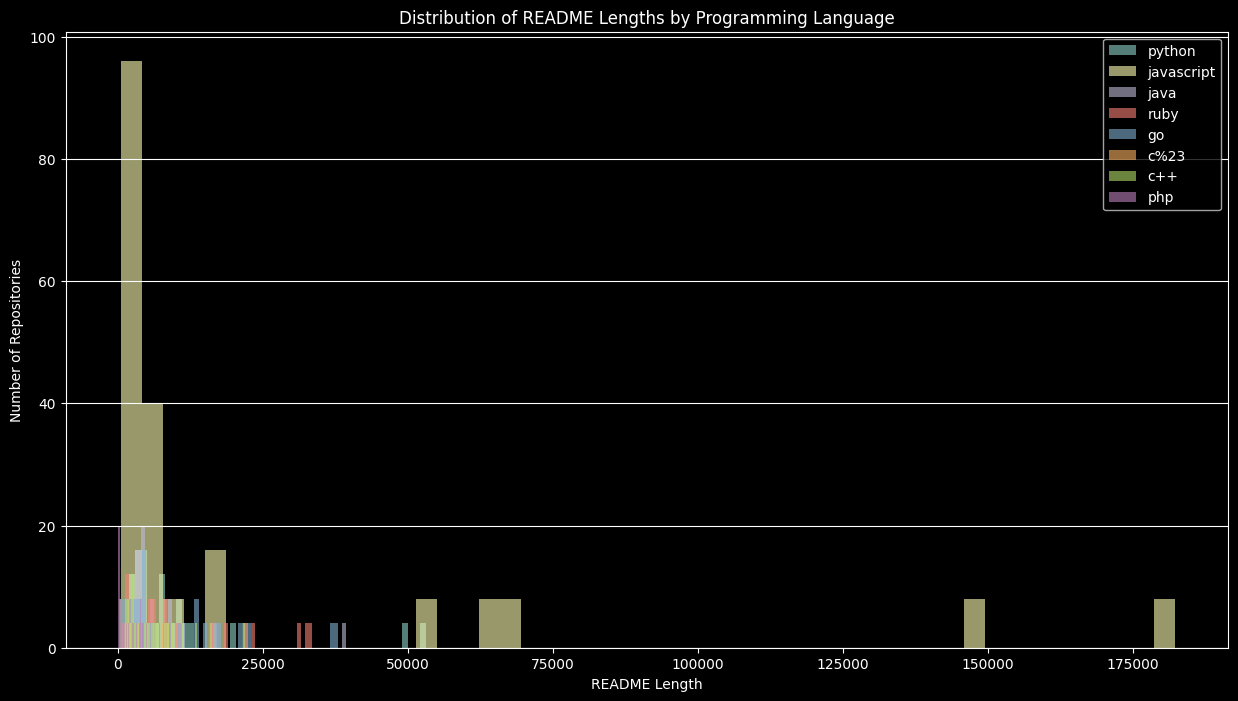

In [17]:
from matplotlib import pyplot as plt


# Calculate the length of each README
repos_df['readme_length'] = repos_df['preprocessed_readme'].apply(len)

# Plot the distribution of README lengths by programming language
plt.figure(figsize=(15, 8))
for lang in repos_df['language'].unique():
    subset = repos_df[repos_df['language'] == lang]
    plt.hist(subset['readme_length'], bins=50, alpha=0.6, label=lang)

plt.title('Distribution of README Lengths by Programming Language')
plt.xlabel('README Length')
plt.ylabel('Number of Repositories')
plt.legend()
plt.grid(axis='y')
plt.show()

In [18]:
# Calculate the max, min, and mean README lengths by programming language
repos_summary = repos_df.groupby('language')['readme_length'].agg(['max', 'min', 'mean'])

# Print the summary table
print(repos_summary)

               max   min          mean
language                              
c%23          8756   794   3826.041667
c++          21976   133   6077.739130
go           38058   382   9613.280000
java         39427   875   6962.720000
javascript  182370   486  24396.240000
php           8943   117   2406.833333
python       53101  1925  11042.920000
ruby         33547   581  10763.375000


Most READMEs, irrespective of the programming language, tend to be similar.

Some languages, such as Java, JavaScript, and Python, have READMEs that span a wider range of lengths, from very short to very long.

Some languages, like C++, have a more concentrated distribution of README lengths, mostly towards the shorter side.

### Number of Unique Words by Programming Language

We'll calculate the number of unique words used in READMEs for each programming language.

In [19]:
# Calculate the number of unique words for each README
repos_df['unique_word_count'] = repos_df['preprocessed_readme'].apply(lambda x: len(set(x.split())))

# Calculate the average number of unique words by programming language
avg_unique_words_by_language = repos_df.groupby('language')['unique_word_count'].mean().sort_values(ascending=False)

avg_unique_words_by_language

language
javascript    863.160000
python        636.560000
ruby          524.333333
go            476.160000
java          431.160000
c++           371.391304
c%23          269.750000
php           188.708333
Name: unique_word_count, dtype: float64

JavaScript repositories tend to have the most diverse vocabulary in their READMEs, with an average of approximately 897 unique words.

Python, Ruby, and Go also have a relatively high number of unique words in their READMEs.

PHP and C# tend to have READMEs with a smaller vocabulary.

### Words Uniquely Identifying a Programming Language

We'll identify words that are highly prevalent in READMEs of one programming language but rare in READMEs of other languages.

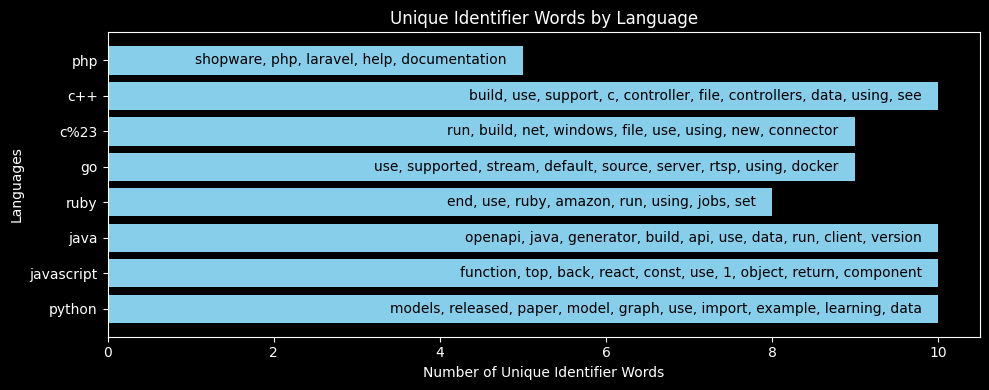

In [20]:
def top_words_for_language(lang, n=10):
    """Get the top n words for a given language."""
    text = " ".join(repos_df[repos_df['language'] == lang]['preprocessed_readme'])
    word_counts = Counter(text.split())
    return word_counts.most_common(n)

def is_word_unique_to_language(word, lang, threshold=0.1):
    """Check if a word is unique to a given language based on a threshold frequency in other languages."""
    total_occurrences = sum([1 for readme in repos_df['preprocessed_readme'] if word in readme])
    lang_occurrences = sum([1 for readme in repos_df[repos_df['language'] == lang]['preprocessed_readme'] if word in readme])
    
    # If the word occurs predominantly in the given language, it's considered unique
    return (lang_occurrences / total_occurrences) > threshold

unique_identifier_words = {}

# For each language, identify potential unique identifier words
for lang in repos_df['language'].unique():
    top_words = [word[0] for word in top_words_for_language(lang)]
    unique_words = [word for word in top_words if is_word_unique_to_language(word, lang)]
    unique_identifier_words[lang] = unique_words

import matplotlib.pyplot as plt

# Extract data for plotting
languages = list(unique_identifier_words.keys())
num_unique_words = [len(unique_identifier_words[lang]) for lang in languages]
unique_words = [", ".join(unique_identifier_words[lang]) for lang in languages]

# Create bar chart
plt.figure(figsize=(10, len(languages) * 0.5))  # Adjusting the height based on number of languages
bars = plt.barh(languages, num_unique_words, color='skyblue')

# Annotate bars with the unique words
for bar, words in zip(bars, unique_words):
    plt.text(bar.get_width() - (0.02 * max(num_unique_words)),  # Positioning the text a bit inside the bar's end
             bar.get_y() + bar.get_height()/2, 
             words, 
             va='center', ha='right', color='black', fontsize=10)

plt.xlabel('Number of Unique Identifier Words')
plt.ylabel('Languages')
plt.title('Unique Identifier Words by Language')
plt.tight_layout()
plt.show()



<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → Explore → </i></font> <font size='10'><i>**Model**</i></font> <font size='5'><i>→ Deliver</i></font>
---

**Representation**:

****`BoW`****: Represents text as raw word counts. For instance, in a document, if the word "apple" appears 5 times, its representation in the **`BoW`** vector would be 5 for that word.

**`TF-IDF`**: Represents text based on the importance of each term relative to the entire corpus. It combines two metrics:
Term Frequency (TF): Measures the frequency of a term in a document (similar to **`BoW`**).
Inverse Document Frequency (IDF): Measures how unique or rare a term is across the entire corpus.

**Weighting**:

**`BoW`**: Gives equal weight to all terms. Common words in a language (like "the", "and", "is") that may appear frequently but offer little value in distinguishing documents will have high values.

**`TF-IDF`**: Weights terms based on their importance in the document relative to the entire corpus. Words that are frequent in a document but not across documents will have high **`TF-IDF`** scores.

**Use Cases**:

**`BoW`**: Given its simplicity, it can be effective for tasks where the sheer occurrence of words is important.

**`TF-IDF`**: Especially useful when you want to understand the importance or significance of words relative to the entire dataset. It can help in tasks like information retrieval, document search, and topic modeling.

**Dimensionality**:

For both **`BoW`** and **`TF-IDF`**, the dimensionality is equal to the size of the vocabulary. However, **`TF-IDF`** usually results in sparser vectors because many term weights will be zero (if the word is not in the document or has zero IDF).

### Term Frequency-Inverse Document Frequency (TF-IDF) 

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the preprocessed READMEs
tfidf_features = tfidf_vectorizer.fit_transform(repos_df['preprocessed_readme'])

# Convert the TF-IDF features to a DataFrame for easier analysis
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [22]:
# Export the tfidf vectorizer into model_files

pickle.dump(tfidf_vectorizer, open('model_files/tfidf_vectorizer.pkl', 'wb'))

In [23]:
# Add the 'language' column to the TF-IDF DataFrame
tfidf_df['language'] = repos_df['language']

tfidf_df.head()

,01,02,03,04,05,06,07,08,09,10,...,write,writing,written,yaml,yes,yet,yield,youll,youre,zero
0,0.0,0.080807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.071813,0.0,0.00000,0.0,0.0,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024193,...,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087838,...,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.01461,0.0,0.0,0.011702,0.0


In [24]:
# Number of top words to display for each language
num_top_words = 10

# Calculate the mean TF-IDF score for each word by programming language
mean_tfidf_by_language = tfidf_df.groupby('language').mean()

# Identify the top words for each language based on the mean TF-IDF score
top_tfidf_words = {}
for lang in mean_tfidf_by_language.index:
    top_words = mean_tfidf_by_language.loc[lang].sort_values(ascending=False).head(num_top_words).index.tolist()
    top_tfidf_words[lang] = top_words

top_tfidf_words

{'c%23': ['net',
  'docker',
  'run',
  'windows',
  'build',
  'file',
  'core',
  'server',
  'use',
  'app'],
 'c++': ['cmake',
  'data',
  'android',
  'build',
  'code',
  'see',
  'release',
  'pcm',
  'use',
  'source'],
 'go': ['kubernetes',
  'cluster',
  'security',
  'see',
  'docker',
  'database',
  'cloud',
  'documentation',
  'go',
  'server'],
 'java': ['java',
  'apache',
  'data',
  'build',
  'test',
  'kafka',
  'maven',
  'code',
  'mysql',
  'database'],
 'javascript': ['const',
  'react',
  'npm',
  'support',
  'install',
  'deploy',
  'function',
  'javascript',
  'use',
  'please'],
 'php': ['component',
  'php',
  'contributing',
  'documentation',
  'issues',
  'send',
  'resources',
  'report',
  'pull',
  'repository'],
 'python': ['models',
  'model',
  'training',
  'learning',
  'data',
  'pip',
  'neural',
  'image',
  'install',
  'dataset'],
 'ruby': ['ruby',
  'gem',
  'end',
  'rails',
  'bundle',
  'use',
  'linux',
  'jobs',
  'data',
  'run']}

C#: .net, docker, blazor, winui, bloxstrap

C++: pcm, electron, memgraph, cmake, clickhouse

Go: kubernetes, tidb, docker, nebula, spire

Java: java, gradlew, build, ghidra, starrocks

JavaScript: react, const, svelte, support, mailcow

PHP: component, symfony, php, doctrine, composer

Python: openmmlab, toolbox, training, model, benchmark

R: package, cell, analysis, data, seurat

Ruby: ruby, gem, rails, jobs, rubocop

Swift: swift, mapbox, ios, xcode, package

### Text Classification Modeling

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_df.drop(columns='language'), 
    tfidf_df['language'], 
    test_size=0.2, 
    random_state=321
)

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=321)
logreg_model.fit(X_train, y_train)

# Predict the programming languages for the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Add the accuracy to the DataFrame
report_df['accuracy'] = accuracy

report_df


,precision,recall,f1-score,support,accuracy
c%23,1.000000,1.000000,1.000000,20.000000,0.960227
c++,0.777778,0.875000,0.823529,16.000000,0.960227
go,1.000000,1.000000,1.000000,18.000000,0.960227
java,1.000000,0.960000,0.979592,25.000000,0.960227
javascript,0.948718,1.000000,0.973684,37.000000,0.960227
php,1.000000,1.000000,1.000000,19.000000,0.960227
python,0.952381,1.000000,0.975610,20.000000,0.960227
ruby,1.000000,0.809524,0.894737,21.000000,0.960227
accuracy,0.960227,0.960227,0.960227,0.960227,0.960227
macro avg,0.959860,0.955565,0.955894,176.000000,0.960227


Improving this performance might require:

- Trying more sophisticated models or ensemble techniques.
- Including more features, like N-grams or word embeddings.
- Acquiring more data, especially for underrepresented languages.
- Hyperparameter tuning for the chosen model.

### N-Grams

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    repos_df['preprocessed_readme'], repos_df['language'], test_size=0.2, random_state=321
)

# Initialize the CountVectorizer with 1-grams and 2-grams
ngram_vectorizer = CountVectorizer(ngram_range=(2, 3))

# Fit the vectorizer on the training data and transform
X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

# Train a logistic regression model
lr_ngram = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
lr_ngram.fit(X_train_ngram, y_train)

# Predict on the train set
y_pred_train_ngram = lr_ngram.predict(X_train_ngram)

# Evaluate the model's performance on the train set
accuracy_train_ngram = accuracy_score(y_train, y_pred_train_ngram)
classification_rep_train_ngram = classification_report(y_train, y_pred_train_ngram, output_dict=True)

# Convert the report dictionary to a DataFrame
n_gram_report_df = pd.DataFrame(classification_rep_train_ngram).transpose()
n_gram_report_df = n_gram_report_df.add_prefix('train_')

# Add the accuracy to the DataFrame
n_gram_report_df['train_accuracy'] = accuracy_train_ngram

n_gram_report_df

,train_precision,train_recall,train_f1-score,train_support,train_accuracy
c%23,1.0,1.0,1.0,76.0,1.0
c++,1.0,1.0,1.0,76.0,1.0
go,1.0,1.0,1.0,82.0,1.0
java,1.0,1.0,1.0,75.0,1.0
javascript,1.0,1.0,1.0,163.0,1.0
php,1.0,1.0,1.0,77.0,1.0
python,1.0,1.0,1.0,80.0,1.0
ruby,1.0,1.0,1.0,75.0,1.0
accuracy,1.0,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,704.0,1.0


In [27]:
# Predict on the test set
y_pred_test_ngram = lr_ngram.predict(X_test_ngram)

# Evaluate the model's performance on the test set
accuracy_test_ngram = accuracy_score(y_test, y_pred_test_ngram)
classification_rep_test_ngram = classification_report(y_test, y_pred_test_ngram, output_dict=True)

# Convert the report dictionary to a DataFrame
test_n_gram_report_df = pd.DataFrame(classification_rep_test_ngram).transpose()
test_n_gram_report_df = test_n_gram_report_df.add_prefix('test_')

# Add the accuracy to the DataFrame
test_n_gram_report_df['test_accuracy'] = accuracy_test_ngram

# Add the test set scores to the train set report DataFrame
n_gram_report_df = n_gram_report_df.join(test_n_gram_report_df['test_accuracy'])

n_gram_report_df

,train_precision,train_recall,train_f1-score,train_support,train_accuracy,test_accuracy
c%23,1.0,1.0,1.0,76.0,1.0,0.977273
c++,1.0,1.0,1.0,76.0,1.0,0.977273
go,1.0,1.0,1.0,82.0,1.0,0.977273
java,1.0,1.0,1.0,75.0,1.0,0.977273
javascript,1.0,1.0,1.0,163.0,1.0,0.977273
php,1.0,1.0,1.0,77.0,1.0,0.977273
python,1.0,1.0,1.0,80.0,1.0,0.977273
ruby,1.0,1.0,1.0,75.0,1.0,0.977273
accuracy,1.0,1.0,1.0,1.0,1.0,0.977273
macro avg,1.0,1.0,1.0,704.0,1.0,0.977273


## Function(ize) It

In [28]:
import re

def clean_text(text):
    # Remove all instances of "\n" with a space
    text = text.replace('\\n', ' ')
    # Remove all newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace hyphens with spaces
    text = re.sub(r'-', ' ', text)
    # Remove non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra white spaces
    text = ' '.join(text.split())
    return text

In [29]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Load the list of stopwords
stop_words = set(stopwords.words('english'))

# Helper function to tokenize the text and remove stopwords
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
# Apply the cleaning function to the 'readme' column
repos_df['cleaned_readme'] = repos_df['readme'].apply(clean_text)

In [31]:
# Apply the preprocessing function to the 'cleaned_readme' column
repos_df['preprocessed_readme'] = repos_df['cleaned_readme'].apply(preprocess_text)

In [7]:
import re
import string
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def predict_language_tf_idf(test_readme):
    # Add a string check
    if not isinstance(test_readme, str):
        raise TypeError("The input must be a string.")
    
    # Load the pickled objects as bytes
    with open("support_files/tfidf_vectorizer.pkl", "rb") as file:
        tfidf_bytes = file.read()

    # Decode the pickled object to extract relevant attributes
    tfidf_data = pickle.loads(tfidf_bytes, encoding='latin1')

    # Extract relevant attributes for TF-IDF vectorizer
    vocabulary_ = tfidf_data.vocabulary_
    idf_ = tfidf_data.idf_

    # Reconstruct the TF-IDF vectorizer with the extracted attributes
    reconstructed_tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary_)
    reconstructed_tfidf_vectorizer.idf_ = idf_

    # Load the list of stopwords
    stop_words = set(stopwords.words('english'))

    # Transform the preprocessed test README using the reconstructed TF-IDF vectorizer
    preprocessed_test_readme = preprocess_text(test_readme)
    tfidf_test_features = reconstructed_tfidf_vectorizer.transform([preprocessed_test_readme])

    # Convert the transformed features to DataFrame for filtering
    tfidf_test_features_df = pd.DataFrame(tfidf_test_features.toarray(), columns=reconstructed_tfidf_vectorizer.get_feature_names_out())

    # Remove the 'language' column from the test features
    tfidf_test_features_df.drop(columns=['language'], inplace=True)

    # Load the logistic regression model
    with open("support_files/logreg_model.pkl", "rb") as file:
        logreg_model = pickle.load(file)

    # Predict using the logistic regression model
    predicted_probabilities = logreg_model.predict_proba(tfidf_test_features_df)[0]

    # Get the top 3 predicted languages and their confidence scores
    top_3_indices = predicted_probabilities.argsort()[-3:][::-1]
    top_3_languages = logreg_model.classes_[top_3_indices]
    top_3_confidences = predicted_probabilities[top_3_indices]

    # Print the top 3 predicted languages and their confidence scores
    for language, confidence in zip(top_3_languages, top_3_confidences):
        print(f"{language}: {confidence:.2f}")

## Testing the Functions (With our pulled Repos)

In [9]:
# Helper function to tokenize the text and remove stopwords
def preprocess_text(text):
    # Remove all instances of "\n" with a space
    text = text.replace('\\n', ' ')
    # Remove all newline characters
    text = re.sub(r'\n', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Replace hyphens with spaces
    text = re.sub(r'-', ' ', text)
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Remove extra white spaces
    text = ' '.join(text.split())
    
    # Load the list of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Add use to the stop_words list
    stop_words.update(['use', 'using', 'used'])
    
    # Add code
    stop_words.update(['code', 'codes'])

    # Tokenize the text and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [3]:
import pandas as pd

# Read in all_readmes_processed
repos_df = pd.read_csv('support_files/all_readmes_processed.csv')

In [10]:
# Get random test README from our dataframe

test_readme = repos_df[['preprocessed_readme', 'language']].sample(1)

display(test_readme['language'])

test_readme = test_readme['preprocessed_readme'].to_string(index=False)

predict_language_tf_idf(test_readme)

306    html
Name: language, dtype: object

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: X has 499 features, but LogisticRegression is expecting 500 features as input.

## Testing the Functions (With a Random README String)

In [11]:
readme = '''BigML Python Bindings
=====================

`BigML <https://bigml.com>`_ makes machine learning easy by taking care
of the details required to add data-driven decisions and predictive
power to your company. Unlike other machine learning services, BigML
creates
`beautiful predictive models <https://bigml.com/gallery/models>`_ that
can be easily understood and interacted with.

These BigML Python bindings allow you to interact with
`BigML.io <https://bigml.io/>`_, the API
for BigML. You can use it to easily create, retrieve, list, update, and
delete BigML resources (i.e., sources, datasets, models and,
predictions). For additional information, see
the `full documentation for the Python
bindings on Read the Docs <http://bigml.readthedocs.org>`_.

This module is licensed under the `Apache License, Version
2.0 <http://www.apache.org/licenses/LICENSE-2.0.html>`_.

Support
-------

Please report problems and bugs to our `BigML.io issue
tracker <https://github.com/bigmlcom/io/issues>`_.

Discussions about the different bindings take place in the general
`BigML mailing list <http://groups.google.com/group/bigml>`_. Or join us
in our `Campfire chatroom <https://bigmlinc.campfirenow.com/f20a0>`_.

Requirements
------------

Only ``Python 3`` versions are currently supported by these bindings.
Support for Python 2.7.X ended in version ``4.32.3``.

The basic third-party dependencies are the
`requests <https://github.com/kennethreitz/requests>`_,
`unidecode <http://pypi.python.org/pypi/Unidecode/#downloads>`_,
`requests-toolbelt <https://pypi.python.org/pypi/requests-toolbelt>`_,
`bigml-chronos <https://pypi.org/project/bigml-chronos>`_,
`msgpack <https://pypi.org/project/msgpack>`_,
`numpy <http://www.numpy.org/>`_ and
`scipy <http://www.scipy.org/>`_ libraries. These
libraries are automatically installed during the basic setup.
Support for Google App Engine has been added as of version 3.0.0,
using the `urlfetch` package instead of `requests`.

The bindings will also use ``simplejson`` if you happen to have it
installed, but that is optional: we fall back to Python's built-in JSON
libraries is ``simplejson`` is not found.

The bindings provide support to use the ``BigML`` platform to create, update,
get and delete resources, but also to produce local predictions using the
models created in ``BigML``. Most of them will be actionable with the basic
installation, but some additional dependencies are needed to use local
``Topic Models`` and Image Processing models. Please, refer to the
`Installation <#installation>`_ section for details.

OS Requirements
~~~~~~~~~~~~~~~

The basic installation of the bindings is compatible and can be used
on Linux and Windows based Operating Systems.
However, the extra options that allow working with
image processing models (``[images]`` and ``[full]``) are only supported
and tested on Linux-based Operating Systems.
For image models, Windows OS is not recommended and cannot be supported out of
the box, because the specific compiler versions or dlls required are
unavailable in general.

Installation
------------

To install the basic latest stable release with
`pip <http://www.pip-installer.org/>`_, please use:

.. code-block:: bash

    $ pip install bigml

Support for local Topic Distributions (Topic Models' predictions)
and local predictions for datasets that include Images will only be
available as extras, because the libraries used for that are not
usually available in all Operative Systems. If you need to support those,
please check the `Installation Extras <#installation-extras>`_ section.

Installation Extras
-------------------

Local Topic Distributions support can be installed using:

.. code-block:: bash

    pip install bigml[topics]

Images local predictions support can be installed using:

.. code-block:: bash

    pip install bigml[images]

The full set of features can be installed using:

.. code-block:: bash

    pip install bigml[full]


WARNING: Mind that installing these extras can require some extra work, as
explained in the `Requirements <#requirements>`_ section.

You can also install the development version of the bindings directly
from the Git repository

.. code-block:: bash

    $ pip install -e git://github.com/bigmlcom/python.git#egg=bigml_python


Running the Tests
-----------------

The tests will be run using `pytest <https://docs.pytest.org/en/7.2.x/>`_.
You'll need to set up your authentication
via environment variables, as explained
in the authentication section. Also some of the tests need other environment
variables like ``BIGML_ORGANIZATION`` to test calls when used by Organization
members and ``BIGML_EXTERNAL_CONN_HOST``, ``BIGML_EXTERNAL_CONN_PORT``,
``BIGML_EXTERNAL_CONN_DB``, ``BIGML_EXTERNAL_CONN_USER``,
``BIGML_EXTERNAL_CONN_PWD`` and ``BIGML_EXTERNAL_CONN_SOURCE``
in order to test external data connectors.

With that in place, you can run the test suite simply by issuing

.. code-block:: bash

    $ pytest

Additionally, `Tox <http://tox.testrun.org/>`_ can be used to
automatically run the test suite in virtual environments for all
supported Python versions.  To install Tox:

.. code-block:: bash

    $ pip install tox

Then run the tests from the top-level project directory:

.. code-block:: bash

    $ tox

Importing the module
--------------------

To import the module:

.. code-block:: python

    import bigml.api

Alternatively you can just import the BigML class:

.. code-block:: python

    from bigml.api import BigML

Authentication
--------------

All the requests to BigML.io must be authenticated using your username
and `API key <https://bigml.com/account/apikey>`_ and are always
transmitted over HTTPS.

This module will look for your username and API key in the environment
variables ``BIGML_USERNAME`` and ``BIGML_API_KEY`` respectively.

Unix and MacOS
--------------

You can
add the following lines to your ``.bashrc`` or ``.bash_profile`` to set
those variables automatically when you log in:

.. code-block:: bash

    export BIGML_USERNAME=myusername
    export BIGML_API_KEY=ae579e7e53fb9abd646a6ff8aa99d4afe83ac291

refer to the next chapters to know how to do that in other operating systems.

With that environment set up, connecting to BigML is a breeze:

.. code-block:: python

    from bigml.api import BigML
    api = BigML()

Otherwise, you can initialize directly when instantiating the BigML
class as follows:

.. code-block:: python

    api = BigML('myusername', 'ae579e7e53fb9abd646a6ff8aa99d4afe83ac291')

These credentials will allow you to manage any resource in your user
environment.

In BigML a user can also work for an ``organization``.
In this case, the organization administrator should previously assign
permissions for the user to access one or several particular projects
in the organization.
Once permissions are granted, the user can work with resources in a project
according to his permission level by creating a special constructor for
each project. The connection constructor in this case
should include the ``project ID``:

.. code-block:: python

    api = BigML('myusername', 'ae579e7e53fb9abd646a6ff8aa99d4afe83ac291',
                project='project/53739b98d994972da7001d4a')

If the project used in a connection object
does not belong to an existing organization but is one of the
projects under the user's account, all the resources
created or updated with that connection will also be assigned to the
specified project.

When the resource to be managed is a ``project`` itself, the connection
needs to include the corresponding``organization ID``:

.. code-block:: python

    api = BigML('myusername', 'ae579e7e53fb9abd646a6ff8aa99d4afe83ac291',
                organization='organization/53739b98d994972da7025d4a')


Authentication on Windows
-------------------------

The credentials should be permanently stored in your system using

.. code-block:: bash

    setx BIGML_USERNAME myusername
    setx BIGML_API_KEY ae579e7e53fb9abd646a6ff8aa99d4afe83ac291

Note that ``setx`` will not change the environment variables of your actual
console, so you will need to open a new one to start using them.


Authentication on Jupyter Notebook
----------------------------------

You can set the environment variables using the ``%env`` command in your
cells:

.. code-block:: bash

    %env BIGML_USERNAME=myusername
    %env BIGML_API_KEY=ae579e7e53fb9abd646a6ff8aa99d4afe83ac291


Alternative domains
-------------------


The main public domain for the API service is ``bigml.io``, but there are some
alternative domains, either for Virtual Private Cloud setups or
the australian subdomain (``au.bigml.io``). You can change the remote
server domain
to the VPC particular one by either setting the ``BIGML_DOMAIN`` environment
variable to your VPC subdomain:

.. code-block:: bash

    export BIGML_DOMAIN=my_VPC.bigml.io

or setting it when instantiating your connection:

.. code-block:: python

    api = BigML(domain="my_VPC.bigml.io")

The corresponding SSL REST calls will be directed to your private domain
henceforth.

You can also set up your connection to use a particular PredictServer
only for predictions. In order to do so, you'll need to specify a ``Domain``
object, where you can set up the general domain name as well as the
particular prediction domain name.

.. code-block:: python

    from bigml.domain import Domain
    from bigml.api import BigML

    domain_info = Domain(prediction_domain="my_prediction_server.bigml.com",
                         prediction_protocol="http")

    api = BigML(domain=domain_info)

Finally, you can combine all the options and change both the general domain
server, and the prediction domain server.

.. code-block:: python

    from bigml.domain import Domain
    from bigml.api import BigML
    domain_info = Domain(domain="my_VPC.bigml.io",
                         prediction_domain="my_prediction_server.bigml.com",
                         prediction_protocol="https")

    api = BigML(domain=domain_info)

Some arguments for the Domain constructor are more unsual, but they can also
be used to set your special service endpoints:

- protocol (string) Protocol for the service
  (when different from HTTPS)
- verify (boolean) Sets on/off the SSL verification
- prediction_verify (boolean) Sets on/off the SSL verification
  for the prediction server (when different from the general
  SSL verification)

**Note** that the previously existing ``dev_mode`` flag:

.. code-block:: python

    api = BigML(dev_mode=True)

that caused the connection to work with the Sandbox ``Development Environment``
has been **deprecated** because this environment does not longer exist.
The existing resources that were previously
created in this environment have been moved
to a special project in the now unique ``Production Environment``, so this
flag is no longer needed to work with them.


Quick Start
-----------

Imagine that you want to use `this csv
file <https://static.bigml.com/csv/iris.csv>`_ containing the `Iris
flower dataset <http://en.wikipedia.org/wiki/Iris_flower_data_set>`_ to
predict the species of a flower whose ``petal length`` is ``2.45`` and
whose ``petal width`` is ``1.75``. A preview of the dataset is shown
below. It has 4 numeric fields: ``sepal length``, ``sepal width``,
``petal length``, ``petal width`` and a categorical field: ``species``.
By default, BigML considers the last field in the dataset as the
objective field (i.e., the field that you want to generate predictions
for).

::

    sepal length,sepal width,petal length,petal width,species
    5.1,3.5,1.4,0.2,Iris-setosa
    4.9,3.0,1.4,0.2,Iris-setosa
    4.7,3.2,1.3,0.2,Iris-setosa
    ...
    5.8,2.7,3.9,1.2,Iris-versicolor
    6.0,2.7,5.1,1.6,Iris-versicolor
    5.4,3.0,4.5,1.5,Iris-versicolor
    ...
    6.8,3.0,5.5,2.1,Iris-virginica
    5.7,2.5,5.0,2.0,Iris-virginica
    5.8,2.8,5.1,2.4,Iris-virginica

You can easily generate a prediction following these steps:

.. code-block:: python

    from bigml.api import BigML

    api = BigML()

    source = api.create_source('./data/iris.csv')
    dataset = api.create_dataset(source)
    model = api.create_model(dataset)
    prediction = api.create_prediction(model, \
        {"petal width": 1.75, "petal length": 2.45})

You can then print the prediction using the ``pprint`` method:

.. code-block:: python

    >>> api.pprint(prediction)
    species for {"petal width": 1.75, "petal length": 2.45} is Iris-setosa

Certainly, any of the resources created in BigML can be configured using
several arguments described in the `API documentation <https://bigml.com/api>`_.
Any of these configuration arguments can be added to the ``create`` method
as a dictionary in the last optional argument of the calls:

.. code-block:: python

    from bigml.api import BigML

    api = BigML()

    source_args = {"name": "my source",
         "source_parser": {"missing_tokens": ["NULL"]}}
    source = api.create_source('./data/iris.csv', source_args)
    dataset_args = {"name": "my dataset"}
    dataset = api.create_dataset(source, dataset_args)
    model_args = {"objective_field": "species"}
    model = api.create_model(dataset, model_args)
    prediction_args = {"name": "my prediction"}
    prediction = api.create_prediction(model, \
        {"petal width": 1.75, "petal length": 2.45},
        prediction_args)

The ``iris`` dataset has a small number of instances, and usually will be
instantly created, so the ``api.create_`` calls will probably return the
finished resources outright. As BigML's API is asynchronous,
in general you will need to ensure
that objects are finished before using them by using ``api.ok``.

.. code-block:: python

    from bigml.api import BigML

    api = BigML()

    source = api.create_source('./data/iris.csv')
    api.ok(source)
    dataset = api.create_dataset(source)
    api.ok(dataset)
    model = api.create_model(dataset)
    api.ok(model)
    prediction = api.create_prediction(model, \
        {"petal width": 1.75, "petal length": 2.45})

Note that the prediction
call is not followed by the ``api.ok`` method. Predictions are so quick to be
generated that, unlike the
rest of resouces, will be generated synchronously as a finished object.

The example assumes that your objective field (the one you want to predict)
is the last field in the dataset. If that's not he case, you can explicitly
set the name of this field in the creation call using the ``objective_field``
argument:


.. code-block:: python

    from bigml.api import BigML

    api = BigML()

    source = api.create_source('./data/iris.csv')
    api.ok(source)
    dataset = api.create_dataset(source)
    api.ok(dataset)
    model = api.create_model(dataset, {"objective_field": "species"})
    api.ok(model)
    prediction = api.create_prediction(model, \
        {'sepal length': 5, 'sepal width': 2.5})


You can also generate an evaluation for the model by using:

.. code-block:: python

    test_source = api.create_source('./data/test_iris.csv')
    api.ok(test_source)
    test_dataset = api.create_dataset(test_source)
    api.ok(test_dataset)
    evaluation = api.create_evaluation(model, test_dataset)
    api.ok(evaluation)

If you set the ``storage`` argument in the ``api`` instantiation:

.. code-block:: python

    api = BigML(storage='./storage')

all the generated, updated or retrieved resources will be automatically
saved to the chosen directory.

Alternatively, you can use the ``export`` method to explicitly
download the JSON information
that describes any of your resources in BigML to a particular file:

.. code-block:: python

    api.export('model/5acea49a08b07e14b9001068',
               filename="my_dir/my_model.json")

This example downloads the JSON for the model and stores it in
the ``my_dir/my_model.json`` file.

In the case of models that can be represented in a `PMML` syntax, the
export method can be used to produce the corresponding `PMML` file.

.. code-block:: python

    api.export('model/5acea49a08b07e14b9001068',
               filename="my_dir/my_model.pmml",
               pmml=True)

You can also retrieve the last resource with some previously given tag:

.. code-block:: python

     api.export_last("foo",
                     resource_type="ensemble",
                     filename="my_dir/my_ensemble.json")

which selects the last ensemble that has a ``foo`` tag. This mechanism can
be specially useful when retrieving retrained models that have been created
with a shared unique keyword as tag.

For a descriptive overview of the steps that you will usually need to
follow to model
your data and obtain predictions, please see the `basic Workflow sketch
<api_sketch.html>`_
document. You can also check other simple examples in the following documents:

- `model 101 <101_model.html>`_
- `logistic regression 101 <101_logistic_regression.html>`_
- `linear regression 101 <101_linear_regression.html>`_
- `ensemble 101 <101_ensemble.html>`_
- `cluster 101 <101_cluster>`_
- `anomaly detector 101 <101_anomaly.html>`_
- `association 101 <101_association.html>`_
- `topic model 101 <101_topic_model.html>`_
- `deepnet 101 <101_deepnet.html>`_
- `time series 101 <101_ts.html>`_
- `fusion 101 <101_fusion.html>`_
- `scripting 101 <101_scripting.html>`_

Additional Information
----------------------

We've just barely scratched the surface. For additional information, see
the `full documentation for the Python
bindings on Read the Docs <http://bigml.readthedocs.org>`_.
Alternatively, the same documentation can be built from a local checkout
of the source by installing `Sphinx <http://sphinx.pocoo.org>`_
(``$ pip install sphinx``) and then running

.. code-block:: bash

    $ cd docs
    $ make html

Then launch ``docs/_build/html/index.html`` in your browser.

How to Contribute
-----------------

Please follow the next steps:

  1. Fork the project on github.com.
  2. Create a new branch.
  3. Commit changes to the new branch.
  4. Send a `pull request <https://github.com/bigmlcom/python/pulls>`_.


For details on the underlying API, see the
`BigML API documentation <https://bigml.com/developers>`_.'''

predict_language_tf_idf(readme)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: X has 499 features, but LogisticRegression is expecting 500 features as input.

<div style="background-color: #; padding: 0px; ">

## <font size='5'><i>Plan → Acquire → Prepare → Explore → Model →</i></font> <font size='10'><i>**Deliver**</i></font>
---